In [1]:
!pip install datasets

In [2]:
# !pip install --upgrade fsspec huggingface_hub
!pip install --upgrade --force-reinstall fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [3]:

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [4]:

# Load the MRPC dataset from the GLUE benchmark
dataset = load_dataset('glue', 'mrpc')

# Split the dataset into training, validation, and test sets
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

In [5]:

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def encode_examples(dataset):
    inputs = tokenizer(
        dataset['sentence1'],
        dataset['sentence2'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    # Convert tensors to NumPy arrays
    inputs = {k: v.numpy() for k, v in inputs.items()}

    # Map original label values to the range [0, num_classes - 1]
    labels = np.array(dataset['label'], dtype=np.int32)
    return inputs, labels

# Encode the training, validation, and test sets
train_inputs, train_labels = encode_examples(train_dataset)
val_inputs, val_labels = encode_examples(val_dataset)
test_inputs, test_labels = encode_examples(test_dataset)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
## Define a custom layer for graph attention
class GraphAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GraphAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Compute the attention weights
        h = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_scores = tf.matmul(h, self.u)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)

        # Apply attention weights to inputs
        output = tf.reduce_sum(inputs * attention_weights, axis=1)

        # Ensure the output shape matches the expected shape
        output = tf.expand_dims(output, axis=1)  # Add an extra dimension
        return output



In [7]:
class HybridModel(tf.keras.Model):
    def __init__(self, num_labels):
        super(HybridModel, self).__init__()
        self.transformer = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
        self.graph_attention = GraphAttention(units=128) # Increase units
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.batch_norm = tf.keras.layers.BatchNormalization() # Add batch normalization
        self.dense_layer = tf.keras.layers.Dense(128, activation='relu') # Increase units
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, inputs):
        transformer_output = self.transformer(inputs)[0]
        attention_output = self.graph_attention(transformer_output)
        output = self.dropout(attention_output)
        output = self.batch_norm(output) # Apply batch normalization
        output = self.dense_layer(output)
        output = self.classifier(output)
        return output


In [8]:
# Initialize the hybrid model
model = HybridModel(num_labels=2)

# Define learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_inputs, train_labels,
                    validation_data=(val_inputs, val_labels),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.6698 - loss: 0.6878 - val_accuracy: 0.6838 - val_loss: 0.6829
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.6792 - loss: 0.6817 - val_accuracy: 0.6838 - val_loss: 0.6774
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.6653 - loss: 0.6779 - val_accuracy: 0.6838 - val_loss: 0.6725
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 271ms/step - accuracy: 0.6694 - loss: 0.6730 - val_accuracy: 0.6838 - val_loss: 0.6678
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 288ms/step - accuracy: 0.6691 - loss: 0.6688 - val_accuracy: 0.6838 - val_loss: 0.6633
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 274ms/step - accuracy: 0.6737 - loss: 0.6640 - val_accuracy: 0.6838 - val_loss: 0.6591
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.6743 - loss: 0.6599 - val_accuracy: 0.6838 - val_loss: 0.6552
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 270ms/step - accuracy: 0.6712 - loss: 0

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.6827 - loss: 0.6456
Validation Loss: 0.6451612710952759, Validation Accuracy: 0.6838235259056091
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - accuracy: 0.6773 - loss: 0.6470
Test Loss: 0.6511896252632141, Test Accuracy: 0.6649275422096252
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step
Precision: 0.664927536231884
Recall: 1.0
F1 Score: 0.7987465181058496
Confusion Matrix:
 [[   0  578]
 [   0 1147]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


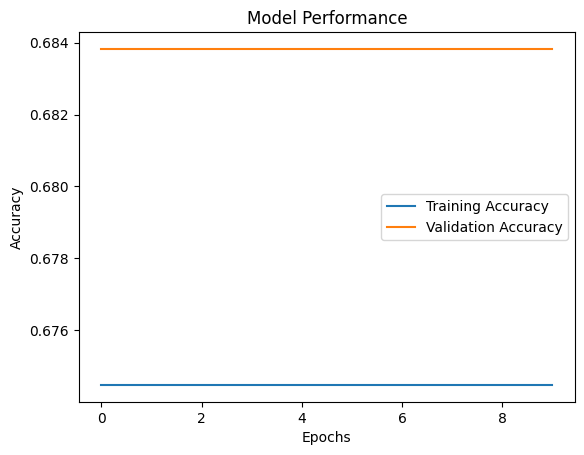

In [9]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = np.argmax(model.predict(test_inputs), axis=-1)

# Calculate additional evaluation metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
conf_matrix = confusion_matrix(test_labels, predictions)
class_report = classification_report(test_labels, predictions)

# Print additional evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plotting performance graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()


In [10]:
class Model(tf.keras.Model):
    def __init__(self, num_labels):
        super(Model, self).__init__()
        self.transformer = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.batch_norm = tf.keras.layers.BatchNormalization() # Add batch normalization
        self.dense_layer = tf.keras.layers.Dense(128, activation='relu') # Increase units
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, inputs):
        output = self.transformer(inputs)[0]
        output = self.dropout(output)
        output = self.batch_norm(output) # Apply batch normalization
        output = self.dense_layer(output)
        output = self.classifier(output)
        return output


# Initialize the model
model2 = Model(num_labels=2)

# Define learning rate scheduler
lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule2)

# Compile the model
model2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history2 = model2.fit(train_inputs, train_labels,
                    validation_data=(val_inputs, val_labels),
                    epochs=10,
                    batch_size=32)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 398ms/step - accuracy: 0.5667 - loss: 0.6739 - val_accuracy: 0.6838 - val_loss: 0.6252
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 65s 293ms/step - accuracy: 0.6815 - loss: 0.6261 - val_accuracy: 0.6838 - val_loss: 0.6245
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - accuracy: 0.6795 - loss: 0.6271 - val_accuracy: 0.6838 - val_loss: 0.6244
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 272ms/step - accuracy: 0.6803 - loss: 0.6273 - val_accuracy: 0.6838 - val_loss: 0.6244
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.6818 - loss: 0.6256 - val_accuracy: 0.6838 - val_loss: 0.6246
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.6734 - loss: 0.6314 - val_accuracy: 0.6838 - val_loss: 0.6235
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.6734 - loss: 0.6315 - val_accuracy: 0.6838 - val_loss: 0.6235
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.6769 - loss: 0

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.6827 - loss: 0.6247
Validation Loss: 0.6238994002342224, Validation Accuracy: 0.6838235259056091
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.6773 - loss: 0.6282
Test Loss: 0.6369267106056213, Test Accuracy: 0.6649275422096252
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step
Precision: 0.664927536231884
Recall: 1.0
F1 Score: 0.7987465181058496
Confusion Matrix:
 [[   0  578]
 [   0 1147]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


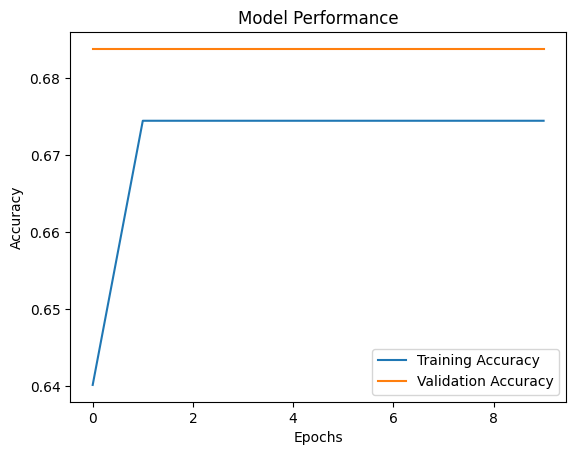

In [11]:
# Evaluate the model on validation set
val_loss2, val_accuracy2 = model2.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss2}, Validation Accuracy: {val_accuracy2}")

# Evaluate the model on test set
test_loss2, test_accuracy2 = model2.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss2}, Test Accuracy: {test_accuracy2}")

# Make predictions on the test set
predictions2 = np.argmax(model2.predict(test_inputs), axis=-1)

# Calculate additional evaluation metrics
precision2, recall2, f1_score2, _ = precision_recall_fscore_support(test_labels, predictions2, average='binary')
conf_matrix2 = confusion_matrix(test_labels, predictions2)
class_report2 = classification_report(test_labels, predictions2)

# Print additional evaluation metrics
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f1_score2)
print("Confusion Matrix:\n", conf_matrix2)
print("Classification Report:\n", class_report2)

# Plotting performance graph
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()
